### 1. Problem Description: Time Series Prediction
The problem we are going to look at is the international airline passengers prediction problem. This is a problem where given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960 or 12 years, with 144 observations.

### 1.1 Load the Dataset

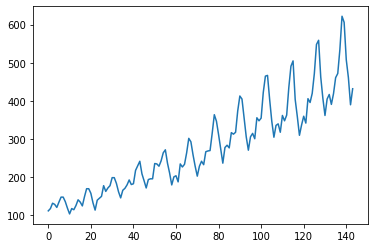

In [14]:
from pandas import read_csv
import matplotlib.pyplot as plt
dataset = read_csv('airline-passengers.csv', usecols=[1]) 
plt.plot(dataset)
plt.show()

You can see an upward trend in the plot. You can also see some periodicity to the dataset that probably corresponds to the northern hemisphere summer holiday period.

### 1.2 Multilayer Perceptron Regression

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense

Extract the NumPy array from the dataframe and convert the integer values to floating point values

In [15]:
dataset = dataset.values
dataset = dataset.astype('float32')

In [20]:
dataset[1:5]

array([[118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

Split dataset into train and test sets

In [16]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Create a function which will take two arguments, the dataset which is a NumPy array that we want to convert into a dataset and the look back which is the number of previous time steps to use as input variables to predict the next time period, in this case, defaulted to 1. This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t+1).

In [33]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Take a look at the effect of this function on the first few rows of the dataset.

In [34]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [38]:
trainX.shape

(94, 1)

In [39]:
trainY.shape

(94,)

In [41]:
print(np.concatenate([testX[1:5],testY[1:5].reshape(-1,1)], axis=1))

[[301. 356.]
 [356. 348.]
 [348. 355.]
 [355. 422.]]


Create a baseline model

In [48]:
# evaluate a persistence model

from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
   # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
   # print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 48.041


We can now fit a Multilayer Perceptron model to the training data. We use a simple network with 1 input, 1 hidden layer with 8 neurons and an output layer. The model is fit using mean squared error, if we take the square root gives us an error score in the units of the dataset.

In [43]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu')) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=0)

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

In [45]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore))) 
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 530.45 MSE (23.03 RMSE)
Test Score: 2351.57 MSE (48.49 RMSE)


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model. Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset.

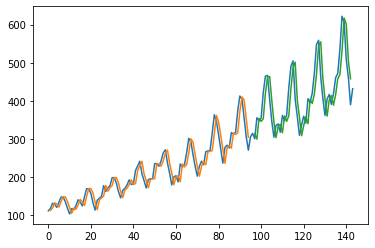

In [46]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### 1.3 Multilayer Perceptron Using the Window Method

We can also phrase the problem so that multiple recent time steps can be used to make the prediction for the next time step. This is called the window method, and the size of the window is a parameter that can be tuned for each problem. For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t) as well as the two prior times (t-1 and t-2). When phrased as a regression problem the input variables are t-2, t-1, t and the output variable is t+1.
The `create dataset()` function we wrote in the previous section allows us to create this formulation of the time series problem by increasing the look back argument from 1 to 3.

In [55]:
look_back2 = 3
trainX2, trainY2 = create_dataset(train, look_back2)
testX2, testY2 = create_dataset(test, look_back2)

In [52]:
print(np.concatenate([testX2[1:5],testY2[1:5].reshape(-1,1)], axis=1))

[[301. 356. 348. 355.]
 [356. 348. 355. 422.]
 [348. 355. 422. 465.]
 [355. 422. 465. 467.]]


In [57]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back2, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX2, trainY2, epochs=400, batch_size=2, verbose=0)
# Estimate model performance
trainScore2 = model.evaluate(trainX2, trainY2, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore2, math.sqrt(trainScore2))) 
testScore2 = model.evaluate(testX2, testY2, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore2, math.sqrt(testScore2)))

Train Score: 591.60 MSE (24.32 RMSE)
Test Score: 2189.19 MSE (46.79 RMSE)


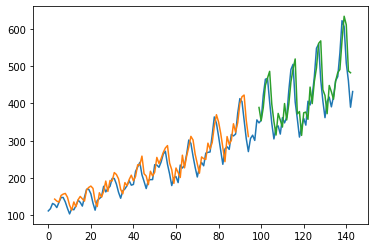

In [59]:
# generate predictions for training
trainPredict = model.predict(trainX2)
testPredict = model.predict(testX2)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back2:len(trainPredict)+look_back2, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back2*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### 1.4 Time Series Prediction with LSTM Recurrent Neural Networks

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or Tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library

In [67]:
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [62]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: `[samples, time steps, features]`. Our prepared data is in the form: `[samples, features]` and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using `numpy.reshape()`

In [81]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(len(train), len(test))
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

96 48


We are now ready to design and fit our LSTM network for this problem. The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM memory blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [82]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

Now let us make the predictions and inverse them using `inverse_transform` method of `scaler`.

In [83]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [84]:
trainPredict[1:5]

array([[0.04340277],
       [0.06733962],
       [0.06217383],
       [0.04849488]], dtype=float32)

In [85]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [86]:
trainPredict[1:5]

array([[126.48263],
       [138.88193],
       [136.20605],
       [129.12035]], dtype=float32)

In [87]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])) 
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.72 RMSE
Test Score: 48.75 RMSE


### 1.5 LSTM For Regression with Time Steps

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

In [89]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [92]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])) 
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 27.89 RMSE
Test Score: 70.64 RMSE
